# EM algorithm test 4

In [6]:
import matplotlib.pyplot as plt
import birdepy as bd
import numpy as np

import os
import sys
sys.path.append('../src/')

from simulate_gillespie import gillespie_linear, discretize_sequence

# Simple linear BDP

In [30]:
## --- Setup --- ##
test_name = "linear_BDP_test"

nsims = 10

N = 100
I0 = 5

time_max = 50.0

# linear BDP rates, $: R_0 > 1
beta = 0.8 # birth rate
mu = 0.55   # death rate


theta_true = (beta, mu)

print(f"Setup for {test_name}")
print(f"N = {N}, I0 = {I0}, time_max = {time_max:.1f}")
print(f"beta = {beta}, mu = {mu}")
print(f"R_0 = {beta / mu:.2f}")

# generate continuously observed data
# discretize it
# plot both

# choose 25 intervals that is 26 observation points
# with dt = (25 - 0)/25 = 1
t_obs_start = 0.0
t_obs_end = 25.0
num_intervals = 25

all_X_cont = [gillespie_linear(N, theta_true, I0, time_max) for _ in range(nsims)]
all_Y_seq = [discretize_sequence(X, t_obs_start, t_obs_end, num_intervals) for X in all_X_cont]

Setup for linear_BDP_test
N = 100, I0 = 5, time_max = 50.0
beta = 0.8, mu = 0.55
R_0 = 1.45
break: time >= time_max
break: time >= time_max
break: k = 0
break: time >= time_max
break: time >= time_max
break: time >= time_max
break: time >= time_max
break: k = 0
break: time >= time_max
break: time >= time_max


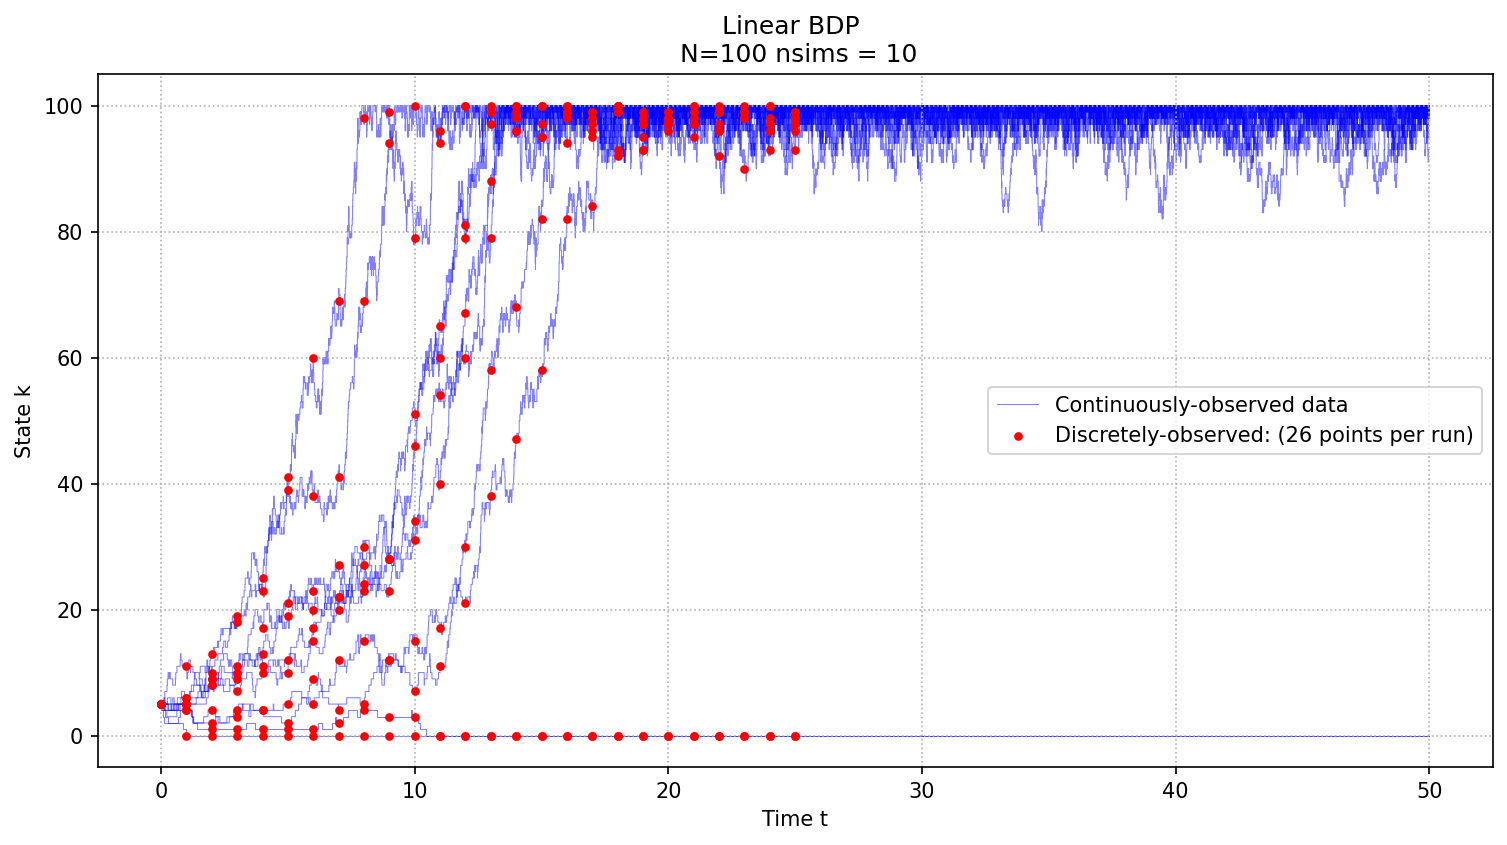

saved to ../figures/estimation/linear_bdp/multi_run_data_plot.pdf


In [33]:
fig, ax = plt.subplots(figsize=(12, 6), dpi=150) # Create figure and axes

for i, (X_times, X_states) in enumerate(all_X_cont):
    ax.step(X_times, X_states, where='post', color='blue', alpha=0.5, linewidth=0.5,
            rasterized=True, zorder=1, label='_nolegend_' if i > 0 else 'Continuously-observed data')

observation_times = np.linspace(t_obs_start, t_obs_end, num_intervals + 1)
all_observed_states_at_times = [] # TODO: plot average

for i, Y_seq in enumerate(all_Y_seq):
    if not Y_seq:
        # skip empty
        continue
    
    observed_states_this_run = [Y_seq[0][0]]
    observed_states_this_run.extend([interval[1] for interval in Y_seq])
    all_observed_states_at_times.append(observed_states_this_run)
    ax.scatter(observation_times, observed_states_this_run,
        color='red', marker='o', s=10, alpha=1, zorder=2,
        label='_nolegend_' if i > 0 else f'Discretely-observed: ({num_intervals + 1} points per run)')


ax.set_title(f"Linear BDP \n N={N} nsims = {nsims}")
ax.set_xlabel("Time t")
ax.set_ylabel("State k")
ax.legend(loc='best')
ax.grid(True, linestyle=':')



output_filename = "../figures/estimation/linear_bdp/multi_run_data_plot.pdf"
plt.savefig(output_filename, format='pdf', bbox_inches='tight')

plt.show()
plt.close(fig)
print(f"saved to {output_filename}")




In [4]:
t_data_list = []
p_data_list = []
for Y_seq in all_Y_seq:
    if Y_seq: # not empty
        obs_times = np.linspace(t_obs_start, t_obs_end, num_intervals + 1)
        obs_states = [Y_seq[0][0]] + [interval[1] for interval in Y_seq]
        t_data_list.append(list(obs_times))
        p_data_list.append(list(obs_states))

## Estimate

In [34]:
# set bounds (0, 5]
p_bounds = [[1e-9, 5.0], [1e-9, 5.0]]

# 25 intervals, means 25 sets of E-step calculations
# E[U | Y], E[D | Y], E[T_part | Y] for each (a, b, dt) in Y

# accelerator='none'

# switching to matrix exponential technique='expm':

p0_guess = [0.6, 0.6]
# run EM until 
# |\theta^{(k + 1)} - \theta^{(k)}| < tol 
# or max_iter is reached
est_em_expm = bd.estimate(
    t_data=t_data_list,
    p_data=p_data_list,
    p0=p0_guess,
    p_bounds=p_bounds,
    framework='em',
    model='linear',
    technique='expm',
    accelerator='Lange', # let's use Lange acceleration
    max_it=100, # max iter
    i_tol=1e-6, # tol
    # laplace_method='cme-talbot', # Default ILT method
    # lentz_eps=1e-6, # Lentz algorithm tolerance
    se_type='asymptotic', # std errors using Hessian
    display=True # show progress
)

Iteration  1  estimate is:  [0.63000786 0.57235712]
Iteration  2  estimate is:  [0.70411188 0.64889554]
Iteration  3  estimate is:  [0.70538766 0.6477471 ]
Iteration  4  estimate is:  [0.70538766 0.6477471 ]


In [39]:
theta_hat = est_em_expm.p
beta_hat = theta_hat[0]
mu_hat = theta_hat[1]

theta_se = est_em_expm.se
beta_se = theta_se[0]
mu_se = theta_se[1]

print(f"beta \t beta_hat \t beta_se \t |beta - beta_hat|")
print(f"{beta:^.4f} \t {beta_hat:^.4f} \t {beta_se:^.4f} \t {np.abs(beta - beta_hat):^.4f}\n")

print(f"mu \t mu_hat \t mu_se  \t |mu - mu_hat|")
print(f"{mu:^.4f} \t {mu_hat:^.4f} \t {mu_se:^.4f} \t {np.abs(mu - mu_hat):^.4f} \n")

beta 	 beta_hat 	 beta_se 	 |beta - beta_hat|
0.8000 	 0.7054 	 0.0611 	 0.0946

mu 	 mu_hat 	 mu_se  	 |mu - mu_hat|
0.5500 	 0.6477 	 0.0611 	 0.0977 

